In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

First, we define the data we want to load. You will need to have the data locally!

In [68]:
data_base = "data/"  # Path to data folder

data_paths = ["aid_received.csv", "gdp_per_capita.csv"]  # File names
data_paths = [data_base + x for x in data_paths]  # Lazy
countries = ["Zimbabwe", "Zambia"]  # Countries we want to study
years = (2000, 2010)

This function loads the data in a messy way.

In [9]:
def load_data(paths: list[str]) -> pd.DataFrame:
    df = None
    for path in paths:
        new_df = pd.read_csv(path).melt(id_vars=["country"], var_name="year",
                                        value_name=path.replace(data_base, "").replace(".csv", ""))
        if df is None:
            df = new_df
        else:
            df = pd.merge(df, new_df, on=["country", "year"])
    df["year"] = df["year"].apply(int)
    return df



Load data frame into memory:

In [69]:
df = load_data(data_paths)
df = df.loc[
    (df["country"].isin(countries)) & (df["year"] > years[0]) & (df["year"] < years[1])]  # Pick out the stuff we want.


In [70]:
df = df.rename(columns={"gdp_per_capita": "gdp_prior"})  # Makes things easier to write
df["gdp_posterior"] = None  # Init new column
for country in countries:  # Bad code! 
    # Creates a x_t+1 column
    df.loc[df["country"] == country, "gdp_posterior"] = df.loc[df["country"] == country, "gdp_prior"].shift(-1)
df = df.dropna()

We say that $x_t = $gdp, and that 
$$
\dot x_t = \alpha x_t + \beta^Tu_t.
$$
Thus, we have the finite time approximation 
$$
x_{t+1} = x_t + \delta t \dot x_t = x_t + \delta t\big( \alpha x_t + \beta^Tu_t \big).
$$
This equation can be rewritten as 
$$
 x_{t+1} - \Big( x_t + \delta t\big( \alpha x_t + \beta^Tu_t \big) \Big) = 0,
$$
and we can describe the model calibration as a MSE loss optimisation 
$$
\min_{\alpha, \beta} \frac{1}{\vert I \vert } \sum_{i \in I} \vert \vert x_{t+1} - \big( x_t + \delta t \dot x_t \big) \vert \vert,
$$
where $I$ is some indexing set for all of our samples. The only contraint we have is $\alpha \in R$ and $\beta\in R^n$, where $n$ is the number of signals we have. 

We do the optimisation via scipy, because I know how to work it. 

In [71]:
import scipy.optimize as opt

In [72]:
def function_to_optimise(x: np.ndarray, X: np.ndarray, delta_t: float) -> float:
    """
    The variable names here are confusing if compared to the previous notation. 
    
    x = [alpha, beta^T]^T, 
    
    X is a (2+n)xm matrix of [x_t, u^T, x_{t+1}], 
    
    delta_t is the time step.
    """

    error_vector = X[:, -1] - ((1 + delta_t * x[0]) * X[:, 0] + delta_t * X[:, 1:-1].dot(x[1:]))
    return error_vector.dot(error_vector)

Now we construct our data matrix, and define our timestep $\delta t = 1 $:

In [91]:
delta_t = 1  # years

# Some book keeping
not_features = ["gdp_prior", "gdp_posterior", "year", "country"]
features = [x for x in df.columns if x not in not_features]


def create_X(df):
    df_size, df_n_features = df.shape[0], df.shape[1] - len(not_features)

    # Init X 
    X = np.zeros((df_size, df_n_features + 2))

    # Assign columns
    X[:, 0] = df["gdp_prior"]
    X[:, 1:-1] = df[features]
    X[:, -1] = df["gdp_posterior"]
    return X, df["year"].to_numpy()


X, _ = create_X(df)

Now we are ready to optimise!

In [92]:

func_lambda = lambda x: function_to_optimise(x, X,
                                             delta_t)  # Create a lambda which passes X and delta_t, since these are constants
initial_guess = np.ones(len(features) + 1)
result = opt.minimize(func_lambda, x0=initial_guess, method='Nelder-Mead')

Now we can look at the result:

In [93]:
print(result)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 53418.39197872642
             x: [-1.176e-01  1.661e+00]
           nit: 51
          nfev: 96
 final_simplex: (array([[-1.176e-01,  1.661e+00],
                       [-1.176e-01,  1.661e+00],
                       [-1.176e-01,  1.661e+00]]), array([ 5.342e+04,  5.342e+04,  5.342e+04]))


Or, we can compare our estimate vs actual for some country of interest


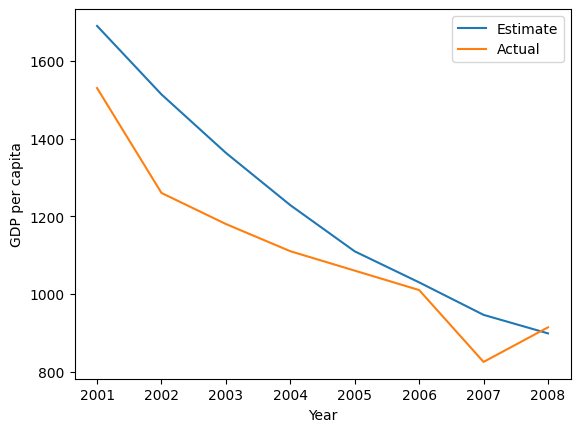

In [101]:
def quick_sim(result, signals, initial_state):
    ret = [initial_state]
    c_state = initial_state
    for k in range(signals.shape[0]-1):
        c_state = c_state + delta_t*(result.x[0]*c_state + signals[k,:].dot(result.x[1:]))
        ret.append(c_state)
    return np.array(ret)


country_of_interest = "Zimbabwe"
sub_df = df.loc[df["country"] == "Zimbabwe"]
sub_X, y = create_X(sub_df)

estimate = quick_sim(result, sub_X[:, 1:-1], initial_state=sub_X[0, 0])
actual = sub_X[:, -1]

plt.plot(y, estimate, label="Estimate")
plt.plot(y, actual, label="Actual")
plt.xlabel("Year")
plt.ylabel("GDP per capita")
plt.legend()


